In [ ]:
# Standard library imports
import os
import shutil
import math
import copy
import random
import gc

# Third-party imports for data handling and scientific computation
import cv2
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import albumentations as Augm
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.transforms import ColorJitter, FancyPCA

# PyTorch imports for deep learning
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.models import resnet50 as _resnet50
from torchsummary import summary

# Other utilities
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 1, Download and unzip data

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

## Augmentation
!pip install -U albumentations

### 2,   1/4 Times: Random Split Training and Test Dataset

In [46]:
########## ONLY RUN THIS CELL CAN ONCE ##########
# Remove if exists, and create train, unlabeled val, test folders
train_path = "./train"
unlabeled_path = "./unlabeled"
val_path = "./val"
test_path = "./test"

for path in [train_path, unlabeled_path, val_path, test_path]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

for path in [train_path, unlabeled_path, val_path, test_path]:
    os.makedirs(os.path.join(path, "benign"))
    os.makedirs(os.path.join(path, "malignant"))

os.makedirs(os.path.join(unlabeled_path, "data"))

# Copy images to train, unlabeled, val folders
df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)

# Define the number of images in each category
N_total = len(img_lis)
N_train = 270
N_unlabeled = 540

# Shuffle the data and split into train, unlabeled, val
shuffle_ix = np.random.permutation(np.arange(N_total))
ix_train = shuffle_ix[:N_train]
ix_unlabeled = shuffle_ix[N_train : N_train + N_unlabeled]
ix_val = shuffle_ix[N_train + N_unlabeled:]

for i in ix_train:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
for i in ix_unlabeled:
    name = img_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./unlabeled/data/"+name+".jpg")
for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")  

# Copy images to test folder
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

# Print out the number of images in each folder
print(f'Number of images: {len(img_lis)}')
print(f'Number of training images: {len(ix_train)}')
print(f'Number of unlabeled images: {len(ix_unlabeled)}')
print(f'Number of validation images: {len(ix_val)}')
print(f'Number of test images: {len(df)+1}')

Number of images: 900
Number of training images: 270
Number of unlabeled images: 540
Number of validation images: 90
Number of test images: 379


### 3.1, Augmentation

In [47]:
BenignTrain_direc = "/content/train/benign"
MaligTrain_direc = "/content/train/malignant/"
BenignVal_direc = "/content/val/benign"
MaligVal_direc = "/content/val/malignant/"

## Train
BenignTrain_filepaths = sorted([os.path.join(BenignTrain_direc, f) for f in os.listdir(BenignTrain_direc)])
MaligTrain_filepaths = sorted([os.path.join(MaligTrain_direc, f) for f in os.listdir(MaligTrain_direc)])
images_filepaths = [*BenignTrain_filepaths, *MaligTrain_filepaths, *MaligTrain_filepaths]
TrainImages_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

## Validation
BenignVal_filepaths = sorted([os.path.join(BenignVal_direc, f) for f in os.listdir(BenignVal_direc)])
MaligVal_filepaths = sorted([os.path.join(MaligVal_direc, f) for f in os.listdir(MaligVal_direc)])
images_filepaths = [*BenignVal_filepaths, *MaligVal_filepaths, *MaligVal_filepaths]
ValImages_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(TrainImages_filepaths)
random.shuffle(ValImages_filepaths)
n_AugTrain = len(TrainImages_filepaths)
n_AugVal = len(ValImages_filepaths)
print(n_AugTrain)
print(n_AugVal)

323
108


In [48]:
class AugmDataSet():
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "malignant":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

# Flipping
GEO = Augm.Compose([
    Augm.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    Augm.HorizontalFlip(p=1),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

# Color Jitter
COL = Augm.Compose([
    Augm.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    ColorJitter(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

# PCA
PCA = Augm.Compose([
    Augm.Resize(224, 224),
    Augm.RandomCrop(width=224, height=224),
    FancyPCA(),
    Augm.RandomBrightnessContrast(p=0.1),
    ToTensorV2()
])

## Train
GEO_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=GEO)
COL_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=COL)
PCA_train_dataset = AugmDataSet(images_filepaths=TrainImages_filepaths, transform=PCA)
## Validation
GEO_val_dataset = AugmDataSet(images_filepaths=ValImages_filepaths, transform=GEO)
COL_val_dataset = AugmDataSet(images_filepaths=ValImages_filepaths, transform=COL)
PCA_val_dataset = AugmDataSet(images_filepaths=ValImages_filepaths, transform=PCA)


### 3.2, Build train, unlabeled, val loaders

In [49]:
# Data augmentation for weak and strong versions
normalization = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug_normalization = transforms.Compose([
    transforms.Resize(244),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.65, std=0.5)
])

# Create unlabeled dataset for ImageFolder problem
class unlabeledDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = self._gather_unlabeled_samples(root)

    def _gather_unlabeled_samples(self, root):
        samples = []
        for filename in os.listdir(root):
            if filename.endswith(".jpg"):
                path = os.path.join(root, filename)
                samples.append((path, -1))  # -1 indicates no label is provided
        return samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = Image.open(path).convert('RGB')
        img = self.transform(img) if self.transform is not None else img
        return img, target

    def __len__(self):
        return len(self.samples)

# Load data in batches
def dataloader(batch_size=12, Aug_Train_dataset=None, Aug_Val_dataset=None):
    if Aug_Train_dataset != None:
        #### Gen & Aug Train data ####
        Augm_train_subset = []
        UnAugm_train_dataset = ImageFolder("./train", transform=normalization)
        n_UnAugm_train = int(len(UnAugm_train_dataset))       ## 270
        n_Augm_train = n_AugTrain                                     ## change accordingly                  

        ## split & combine train dataset
        UnAugm_train_subset = torch.utils.data.Subset(UnAugm_train_dataset, range(n_UnAugm_train))
        for dataset in Aug_Train_dataset:
            Augm_train_subset.append(torch.utils.data.Subset(dataset, range(n_Augm_train)))
        train_dataset = torch.utils.data.ConcatDataset([UnAugm_train_subset, Augm_train_subset[0],
                                                        Augm_train_subset[1], Augm_train_subset[2]])
    else:
        train_dataset = ImageFolder('./train', transform=aug_normalization)
    
    if Aug_Val_dataset != None:     
        #### Gen & Aug Validation data ####
        Augm_val_subset = []
        UnAugm_val_dataset = ImageFolder("./val", transform=normalization)
        n_UnAugm_val = int(len(UnAugm_val_dataset))       ## 270
        n_Augm_val = n_AugVal                                     ## change accordingly                  

        ## split & combine Validation dataset
        UnAugm_val_subset = torch.utils.data.Subset(UnAugm_val_dataset, range(n_UnAugm_val))
        for dataset in Aug_Val_dataset:
            Augm_val_subset.append(torch.utils.data.Subset(dataset, range(n_Augm_val)))
        val_dataset = torch.utils.data.ConcatDataset([UnAugm_val_dataset, Augm_val_subset[0],
                                                        Augm_val_subset[1], Augm_val_subset[2]])
    else:
        val_dataset = ImageFolder('./val', transform=normalization)

    unlabeled_dataset = unlabeledDataset('./unlabeled/data', transform=normalization)
    test_dataset = ImageFolder('./test', transform=normalization)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, unlabeled_loader, val_loader, test_loader

batch_size = 32
AUG_TYPE_LIST = [GEO_train_dataset, COL_train_dataset, PCA_train_dataset]
train_loader, unlabeled_loader, val_loader, test_loader = dataloader(batch_size, Aug_Train_dataset=AUG_TYPE_LIST)

# Checkpoint
print(f'Shape of image: {train_loader.dataset[0][0].shape}')        #[3, 224, 224]
print(f'Number of training batches: {len(train_loader)}')           #23
print(f'Number of unlabeled batches: {len(unlabeled_loader)}')      #45
print(f'Number of validation batches: {len(val_loader)}')           #8
print(f'Number of test batches: {len(test_loader)}')                #32

Shape of image: torch.Size([3, 224, 224])
Number of training batches: 39
Number of unlabeled batches: 17
Number of validation batches: 3
Number of test batches: 12


### 4, Build the network

In [42]:
# 3x3 Convolutional Layer
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# Basic Block with 2 Convolutional Layers
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Bottleneck Block with 3 Convolutional Layers
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Customized ResNet Architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

# Create ResNet50 Model with / without Pre-trained Weights and dropout
def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=0.5)
    if pre_trained:
        pre_trained_model = _resnet50(weights = "IMAGENET1K_V2")
        pre_trained = pre_trained_model.state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

# Define the high-level model
class Model(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(Model, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x

# Print the summary
input_size = (3, 224, 224)  # Input size for ResNet-50 model (channels, height, width)
#summary(model, input_size)

### 5.1, 1/4 Times: Train Model

In [ ]:
def gpu_clean():
    gc.collect()
    torch.cuda.empty_cache()

In [50]:
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.6, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        alpha = self.alpha
        gamma = self.gamma
        loss = - alpha * (1 - logits) ** gamma * target * torch.log(logits) - \
               (1 - alpha) * logits ** gamma * (1 - target) * torch.log(1 - logits)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss
        
class MeanTeacherModel(nn.Module):
    def __init__(self, student_model, ema_decay):
        super().__init__()
        self.student_model = student_model
        self.teacher_model = copy.deepcopy(student_model)
        self.ema_decay = ema_decay

    def forward(self, x):
        return self.student_model(x)

    def update_teacher_model(self):
        with torch.no_grad():
            for student_params, teacher_params in zip(self.student_model.parameters(), self.teacher_model.parameters()):
                teacher_params.data.mul_(self.ema_decay).add_((1-self.ema_decay) * student_params.data)

    def sigmoid_rampup(self, current_epoch):
        current = np.clip(current_epoch, 0.0, 15.0)
        phase = 1.0 - current / 15.0
        return np.exp(-5.0 * phase * phase).astype(np.float32)

    def get_consistency_weight(self, epoch):
        return 100 * self.sigmoid_rampup(epoch)


def train_mean_teacher(model, labeled_loader, unlabeled_loader, val_loader, optimizer, consistency_criterion, supervised_criterion, device, epochs):
    loss_train_list = []
    unlabeled_auc_train_list = []
    unlabeled_acc_train_list = []
    auc_val_list = []
    acc_val_list = []
    model.student_model.train()
    model.teacher_model.train()
    for epoch in range(epochs):
        gpu_clean()
        unlabeled_lbl, unlabeled_pred = [], [] ## for AUC
        total_loss_train = 0
        for (labeled_imgs, labeled_targets), (unlabeled_imgs, _) in zip(labeled_loader, unlabeled_loader):
            labeled_imgs = labeled_imgs.to(device)
            labeled_targets = labeled_targets.to(device)
            unlabeled_imgs = unlabeled_imgs.to(device)
            
            optimizer.zero_grad()

            # Labeled data
            if labeled_imgs.dtype != torch.float32:
                labeled_imgs = labeled_imgs.float()
            labeled_preds = model.student_model(labeled_imgs)
            labeled_targets = labeled_targets.unsqueeze(1)
            labeled_targets = labeled_targets.float()
            supervised_loss = supervised_criterion(labeled_preds, labeled_targets)

            # Unlabeled data
            unlabeled_preds_student = model.student_model(unlabeled_imgs)
            with torch.no_grad():
                unlabeled_preds_teacher = model.teacher_model(unlabeled_imgs)
            unlabeled_scores = list(unlabeled_preds_student.detach().cpu().numpy())
            unlabeled_true = list(np.around(unlabeled_preds_teacher.detach().cpu().numpy()))  ## make teacher outputs as binary label
            unlabeled_pred += unlabeled_scores
            unlabeled_lbl += unlabeled_true

            # Consistency loss and total loss
            consistency_weights = model.get_consistency_weight(epoch)
            consistency_loss = consistency_weights * consistency_criterion(unlabeled_preds_student, unlabeled_preds_teacher) / batch_size   ## global var = 12

            # Backward pass and optimization
            loss = supervised_loss + consistency_loss
            loss.backward()
            optimizer.step()

            # Update teacher model parameters
            model.update_teacher_model()
            total_loss_train += loss.item()

        # Unlabeled metrics
        unlabeled_lbl, unlabeled_pred = np.array(unlabeled_lbl), np.array(unlabeled_pred)
        unlabeled_pred_lbl = np.around(unlabeled_pred)
        unlabeled_train_auc = roc_auc_score(unlabeled_lbl, unlabeled_pred)  ## sometime pred will all false
        unlabeled_train_acc = accuracy_score(unlabeled_lbl, unlabeled_pred_lbl)
        unlabeled_acc_train_list.append(unlabeled_train_acc)
        unlabeled_auc_train_list.append(unlabeled_train_auc)

        # Validation
        gpu_clean()
        val_lbl, val_pred = [], [] ## for AUC
        for (imgs, targets) in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            if imgs.dtype != torch.float32:
                imgs = imgs.float()
            preds = model.student_model(imgs)
            targets = targets.unsqueeze(1)
            targets = targets.float()

            val_scores = list(preds.detach().cpu().numpy())
            val_true = list(targets.detach().cpu().numpy())
            val_pred += val_scores
            val_lbl += val_true
        
        val_lbl, val_pred = np.array(val_lbl), np.array(val_pred)
        val_pred_lbl = np.around(val_pred)
        val_auc = roc_auc_score(val_lbl, val_pred)
        val_acc = accuracy_score(val_lbl, val_pred_lbl)
        acc_val_list.append(val_acc)
        auc_val_list.append(val_auc)

        loss_train_list.append(total_loss_train)
        my_lr_scheduler.step()
        print("Epoch [{}/{}], Loss: {:.4f}, Unlabeled Train Acc: {:.4f}%, Unlabeled Train AUC: {:.4f}, Val Acc: {:.4f}%, Val AUC: {:.4f}".format(
            epoch+1,epochs,
            total_loss_train/len(labeled_loader),
            unlabeled_acc_train_list[-1]*100,
            unlabeled_auc_train_list[-1],
            acc_val_list[-1]*100,
            auc_val_list[-1]
        ))


    return model, loss_train_list, unlabeled_acc_train_list, unlabeled_auc_train_list, acc_val_list, auc_val_list


resnet50 = get_resnet50(pre_trained=True)
model = Model(resnet50, 1)
model = model.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = model
student_model.to(device)

mean_teacher_model = MeanTeacherModel(student_model, ema_decay=0.99)
mean_teacher_model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
consistency_criterion = nn.MSELoss()
supervised_criterion = BCEFocalLoss()

max_epoch = 25
my_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=max_epoch)
mean_teacher_model, TRAIN_LOSS, UNLAB_ACC_TRAIN, UNLAB_AUC_TRAIN, ACC_VAL, AUC_VAL = train_mean_teacher(mean_teacher_model, train_loader, unlabeled_loader, val_loader, 
                                                                                            optimizer, consistency_criterion, supervised_criterion, device, epochs=max_epoch)

Using dropout.
Epoch [1/25], Loss: 0.0305, Unlabeled Train Acc: 61.6667%, Unlabeled Train AUC: 0.6743, Val Acc: 77.7778%, Val AUC: 0.5494
Epoch [2/25], Loss: 0.0245, Unlabeled Train Acc: 67.2222%, Unlabeled Train AUC: 0.6667, Val Acc: 72.2222%, Val AUC: 0.5548
Epoch [3/25], Loss: 0.0176, Unlabeled Train Acc: 71.8519%, Unlabeled Train AUC: 0.7234, Val Acc: 77.7778%, Val AUC: 0.6281
Epoch [4/25], Loss: 0.0132, Unlabeled Train Acc: 75.0000%, Unlabeled Train AUC: 0.7553, Val Acc: 70.0000%, Val AUC: 0.6049
Epoch [5/25], Loss: 0.0095, Unlabeled Train Acc: 80.0000%, Unlabeled Train AUC: 0.8156, Val Acc: 70.0000%, Val AUC: 0.6049
Epoch [6/25], Loss: 0.0091, Unlabeled Train Acc: 82.2222%, Unlabeled Train AUC: 0.8080, Val Acc: 68.8889%, Val AUC: 0.5764
Epoch [7/25], Loss: 0.0085, Unlabeled Train Acc: 81.1111%, Unlabeled Train AUC: 0.8450, Val Acc: 65.5556%, Val AUC: 0.5502
Epoch [8/25], Loss: 0.0097, Unlabeled Train Acc: 79.2593%, Unlabeled Train AUC: 0.8131, Val Acc: 71.1111%, Val AUC: 0.5509
E

### 5.2, Test model

In [51]:
# Evaluation
mean_teacher_model.eval()
test_lbl, test_pred = [], []

for data in test_loader:
    test_images, test_labels = data
    test_images = test_images.to(device)
    test_labels = test_labels.float().to(device)
    test_outputs = mean_teacher_model.student_model(test_images)[:, 0]
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores
        
test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)
print(test_auc, test_acc)

0.5964473684210526 0.7941952506596306


### 6, plot your training and test curves

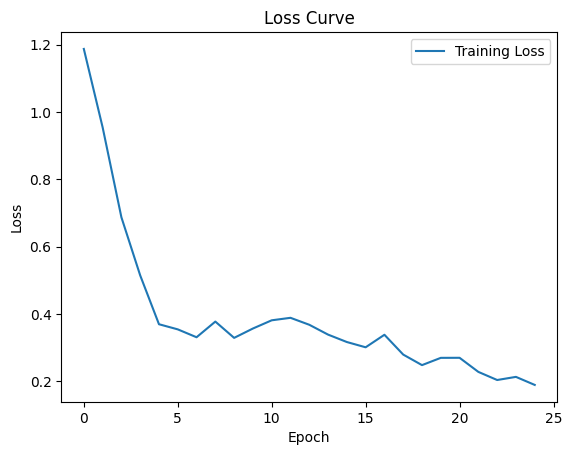

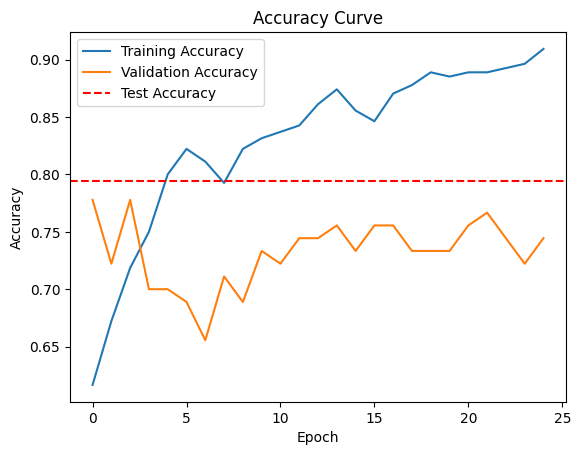

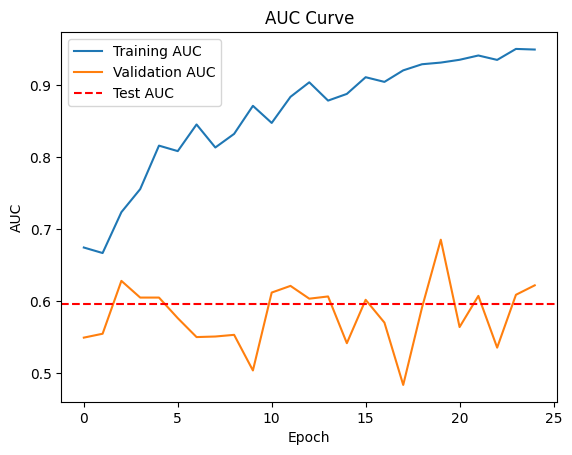

In [52]:
# Plot loss curve
fig = plt.figure()
plt.plot(TRAIN_LOSS, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot accuracy curve
fig = plt.figure()
plt.plot(UNLAB_ACC_TRAIN, label='Training Accuracy')
plt.plot(ACC_VAL, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# Plot AUC curve
fig = plt.figure()
plt.plot(UNLAB_AUC_TRAIN, label='Training AUC')
plt.plot(AUC_VAL, label='Validation AUC')
plt.axhline(y=test_auc, color='r', linestyle='--', label='Test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Curve')
plt.legend()
plt.show()